## TP1: Conditional Generative Adversarial Network on Fashion-mnist Dataset

### Pin JIN, ENSTA Paris

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
import imageio.v2 as imageio
import matplotlib.pyplot as plt

/home/jinpin/.conda/envs/ia329/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load fashion-mnist dataset

In [2]:
class dataloader:
    
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.dataloader = self.load_data(batch_size)

    def load_data(self, batch_size=64):
        transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=(0.5,), std=(0.5, ))
        ])
        fashion_mnist = datasets.FashionMNIST(
            'data', 
            train=True, 
            download=True, 
            transform=transform
        )
        data_loader = DataLoader(
            fashion_mnist, 
            batch_size=batch_size, 
            shuffle=True
        )
        return data_loader

### Model definations

In [3]:
class generator(nn.Module):

    def __init__(
            self, 
            input_dim=100, 
            output_dim=1, 
            input_size=28, 
            class_num=10,
            hidden_dims=[1024, 128, 64],
        ):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num
        self.hidden_dims = hidden_dims

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, self.hidden_dims[0]),
            nn.BatchNorm1d(self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], self.hidden_dims[1] * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(self.hidden_dims[1] * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_dims[1], self.hidden_dims[2], 4, 2, 1),
            nn.BatchNorm2d(self.hidden_dims[2]),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_dims[2], self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, self.hidden_dims[1], (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x

In [4]:
class discriminator(nn.Module):

    def __init__(
            self, 
            input_dim=1, 
            output_dim=1, 
            input_size=28, 
            class_num=10,
            hidden_dims=[64, 128, 1024],
            alpha=0.2,
        ):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num
        self.hidden_dims = hidden_dims
        self.alpha = alpha

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim + self.class_num, self.hidden_dims[0], 4, 2, 1),
            nn.BatchNorm2d(self.hidden_dims[0]),
            nn.LeakyReLU(self.alpha),
            nn.Conv2d(self.hidden_dims[0], self.hidden_dims[1], 4, 2, 1),
            nn.BatchNorm2d(self.hidden_dims[1]),
            nn.LeakyReLU(self.alpha),
        )
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_dims[1] * (self.input_size // 4) * (self.input_size // 4), self.hidden_dims[2]),
            nn.BatchNorm1d(self.hidden_dims[2]),
            nn.LeakyReLU(self.alpha),
            nn.Linear(self.hidden_dims[2], self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(-1, self.hidden_dims[1] * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [5]:
class CGAN(nn.Module):
    
    def __init__(
            self, 
            z_dim=100, 
            channel_dim=1, 
            input_size=28, 
            class_num=10,
            lr_generator=0.0002,
            lr_discriminator=0.0002,
            beta1=0.9,
            beta2=0.999,
            hidden_dims_g=[1024, 128, 64],
            hidden_dims_d=[64, 128, 1024],
            alpha=0.2,
        ):
        super(CGAN, self).__init__()
        self.channel_dim = channel_dim
        self.input_size = input_size
        self.class_num = class_num
        self.z_dim = z_dim
        self.lr_generator = lr_generator
        self.lr_discriminator = lr_discriminator
        self.beta1 = beta1
        self.beta2 = beta2
        self.hidden_dims_g = hidden_dims_g
        self.hidden_dims_d = hidden_dims_d
        self.alpha = alpha
        
        self.generator = generator(
            input_dim=self.z_dim, 
            output_dim=self.channel_dim, 
            input_size=self.input_size, 
            class_num=self.class_num,
            hidden_dims=self.hidden_dims_g,
        )
        self.discriminator = discriminator(
            input_dim=self.channel_dim, 
            output_dim=self.channel_dim, 
            input_size=self.input_size, 
            class_num=self.class_num,
            hidden_dims=self.hidden_dims_d,
            alpha=self.alpha,
        )
        self.generator_optimizer = optim.Adam(
            self.generator.parameters(),
            lr=self.lr_generator, 
            betas=(self.beta1, self.beta2)
        )
        self.discriminator_optimizer = optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr_discriminator, 
            betas=(self.beta1, self.beta2)
        )
        self.BCE_loss = nn.BCELoss()
    
    def print_arch(self):
        print('---------- Networks architecture -------------')
        self.print_net(self.generator, 'Generator')
        self.print_net(self.discriminator, 'Discriminator')
        print('-----------------------------------------------')

    def print_net(self, net, name):
        num_params = 0
        for param in net.parameters():
            num_params += param.numel()
        print()
        print(net)
        print('Total number of %s parameters: %d' % (name, num_params))

### Training process recoder 

In [6]:
class record():
    
    def __init__(
            self,
            save_dir = './models',
            result_dir = './results',
            log_dir = './logs',
            model_name = 'CGAN',
        ):
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.log_dir = log_dir
        self.model_name = model_name

    def save_model(self, name, model):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        path = os.path.join(self.save_dir, self.model_name + '_' + name + '.pkl')
        torch.save(model.state_dict(), path)

    def save_train_history(self, train_history_dict):
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        path = os.path.join(self.log_dir, self.model_name + '_train_history.pkl')
        with open(path, 'wb') as f:
            pickle.dump(train_history_dict, f)

    def load_model(self, name, model):
        path = os.path.join(self.save_dir, self.model_name + '_' + name + '.pkl')
        model.load_state_dict(torch.load(path))

    def loss_plot(self, hist, type):
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        plt.figure()
        if type == 'generator':
            y_g = hist['generator_loss']
            x = range(len(y_g))
            plt.plot(x, y_g, label='generator_loss.png')
            path = os.path.join(self.log_dir, 'generator_loss.png')
        elif type == 'discriminator':
            y_d = hist['discriminator_loss']
            x = range(len(y_d))
            plt.plot(x, y_d, label='discriminator_loss')
            path = os.path.join(self.log_dir, 'discriminator_loss.png')
        elif type == 'both':
            y_g = hist['generator_loss']
            y_d = hist['discriminator_loss']
            x = range(len(y_g))
            plt.plot(x, y_g, label='generator_loss')
            plt.plot(x, y_d, label='discriminator_loss')
            path = os.path.join(self.log_dir, self.model_name + '_loss.png')
        else:
            raise ValueError('type should be selected in "generator", "discriminator", or "both"')
        plt.xlabel('Iter')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

    def generate_animation(self, num_epoch):        
        images = []
        for e in range(num_epoch):
            img_name = self.result_dir + '/' + self.model_name + '_epoch_%03d' % (e+1) + '.png'
            images.append(imageio.imread(img_name))
        path = self.result_dir + '/' + self.model_name + '_animation.gif'
        imageio.mimsave(path, images, fps=5)

    def visualize_results(self, generator, epoch, sample_z_, sample_y_, class_num):
        generator.eval()
        if not os.path.exists(self.result_dir):
            os.makedirs(self.result_dir)
        samples = generator(sample_z_, sample_y_)
        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        if epoch == -1:
            path = self.result_dir + '/' + self.model_name + '_test.png'
            self.save_images(samples, path, class_num, show=True)
        else:
            path = self.result_dir + '/' + self.model_name + '_epoch_%03d' % epoch + '.png'
            self.save_images(samples, path, class_num)

    def save_images(self, images, path, class_num, show=False):
        # [N, H, W, C], here C = 1 ---> [N, H, W]
        images = (((images + 1) / 2) * 255).astype(np.uint8).squeeze(3) 
        grid = self.make_grid(images, class_num)
        plt.imsave(path, grid, cmap='gray')
        if show:
            plt.imshow(grid, cmap='gray')
            plt.axis('off')
            plt.show()

    def make_grid(self, images, class_num):
        N, H, W = images.shape
        grid_size = N // class_num
        grid = np.zeros((grid_size * H, class_num * W), dtype=images.dtype)
        for idx, image in enumerate(images):
            i = idx // class_num
            j = idx % class_num
            grid[i*H:(i+1)*H, j*W:(j+1)*W] = image
        return grid
    
    def show_images(self, class_types, images):
        images = ((images + 1) / 2) * 255
        for i in range(len(class_types)):
            print('Class:', int(class_types[i][0]))
            image = images[i].cpu().detach().numpy()[0]
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()

### Vector generator

In [7]:
class vector_sampler():
    
    def __init__(self, z_dim, class_num, sample_num):
        self.z_dim = z_dim
        self.class_num = class_num
        self.sample_num = sample_num
        self.repeat_times = sample_num // class_num

    def sample_z(self, sample_times):
        return torch.rand(sample_times, self.z_dim)
    
    def sample_classes(self, sample_times):
        return torch.randint(0, self.class_num, (sample_times, 1))

    def process_given_classes(self, class_nums):
        return torch.zeros(len(class_nums), self.class_num).scatter_(1, class_nums.type(torch.LongTensor), 1)
    
    def fix_noise(self):
        z = self.sample_z(self.repeat_times)
        z = z.repeat_interleave(self.class_num, dim=0)
        return z

    def fix_condition(self):
        temp = torch.tensor([[i] for i in range(self.class_num)])
        temp = temp.repeat(self.repeat_times, 1)
        onehot_class = torch.zeros((self.sample_num, self.class_num)).scatter_(1, temp.type(torch.LongTensor), 1)
        return onehot_class
        

In [8]:
class runner():
    
    def __init__(self, params:dict):
        
        ########## hyperparameters ##########
        # class runner
        self.epoch = params['epoch']
        self.batch_size = params['batch_size']
        self.device = params['device']
        
        # class record
        self.save_dir = params['save_dir']
        self.result_dir = params['result_dir']
        self.log_dir = params['log_dir']
        self.model_name = params['model_name']

        # class noise
        self.z_dim = params['z_dim']
        self.class_num = params['class_num']
        self.sample_num = params['sample_num']

        # class cgan
        self.input_size = params['input_size']
        self.channel_dim = params['channel_dim']
        self.lr_generator = params['lr_generator']
        self.lr_discriminator = params['lr_discriminator']
        self.beta1 = params['beta1']
        self.beta2 = params['beta2']
        self.hidden_dims_g = params['hidden_dims_g']
        self.hidden_dims_d = params['hidden_dims_d']
        self.alpha = params['alpha']
        #####################################

        # load dataset
        self.data_loader = dataloader(self.batch_size).dataloader

        # networks 
        self.cgan = CGAN(
            self.z_dim, 
            self.channel_dim, 
            self.input_size, 
            self.class_num,
            self.lr_generator,
            self.lr_discriminator,
            self.beta1,
            self.beta2,
            self.hidden_dims_g,
            self.hidden_dims_d,
            self.alpha,
        )
        self.generator = self.cgan.generator
        self.discriminator = self.cgan.discriminator
        self.generator_optimizer = self.cgan.generator_optimizer
        self.discriminator_optimizer = self.cgan.discriminator_optimizer
        self.BCE_loss = self.cgan.BCE_loss

        # record model & process
        self.record = record(
            self.save_dir, 
            self.result_dir, 
            self.log_dir, 
            self.model_name
        )

        # generator for test
        self.test_generator = generator(
            input_dim=self.z_dim, 
            output_dim=self.channel_dim, 
            input_size=self.input_size, 
            class_num=self.class_num
        )

        # vector sampler
        self.vector_sampler = vector_sampler(
            self.z_dim, 
            self.class_num, 
            self.sample_num
        )

    def train(self):
        
        self.train_hist = {}
        self.train_hist['discriminator_loss'] = []
        self.train_hist['generator_loss'] = []

        self.latent_z = self.vector_sampler.fix_noise()
        self.onehot_class = self.vector_sampler.fix_condition()

        self.value_real = torch.ones(self.batch_size, 1)
        self.value_fake = torch.zeros(self.batch_size, 1)

        self.cgan, self.latent_z, self.onehot_class, self.value_real, self.value_fake = \
            self.cgan.to(self.device), self.latent_z.to(self.device), self.onehot_class.to(self.device), \
            self.value_real.to(self.device), self.value_fake.to(self.device)

        self.discriminator.train()
        print("Each epoch has", len(self.data_loader)-1, "iterations.")
        for epoch in tqdm(range(self.epoch), desc="Training", unit="epoch"):
            self.generator.train()
            # (batch_idx, (data, target)): number, [batch_size, C, H, W], [batch_size]
            for iter, (data_x, data_y) in enumerate(self.data_loader): 
                if iter == len(self.data_loader)-1:
                    break

                z = self.vector_sampler.sample_z(self.batch_size)
                label = self.vector_sampler.process_given_classes(data_y.unsqueeze(1))      # [batch_size, class_num]
                label_imagesize = label.unsqueeze(2).unsqueeze(3).expand(               
                    self.batch_size, self.class_num, self.input_size, self.input_size       # [batch_size, class_num, H, W]
                )
                
                # load local data to device
                data_x, z = data_x.to(self.device), z.to(self.device)
                label, label_imagesize = label.to(self.device), label_imagesize.to(self.device)

                # update discriminator
                self.discriminator_optimizer.zero_grad()

                # real data loss
                judge_realdata = self.discriminator(data_x, label_imagesize)
                discriminator_loss_realdata = self.BCE_loss(judge_realdata, self.value_real)

                # fake data loss
                fake_data_x = self.generator(z, label)
                judge_fakedata = self.discriminator(fake_data_x, label_imagesize)
                discriminator_loss_fakedata = self.BCE_loss(judge_fakedata, self.value_fake)

                # total loss
                discriminator_loss = discriminator_loss_realdata + discriminator_loss_fakedata
                self.train_hist['discriminator_loss'].append(discriminator_loss.item())

                # backpropagation of discriminator
                discriminator_loss.backward()
                self.discriminator_optimizer.step()

                # update generator
                self.generator_optimizer.zero_grad()

                fake_data_x = self.generator(z, label)
                judge_fakedata = self.discriminator(fake_data_x, label_imagesize)
                generator_loss = self.BCE_loss(judge_fakedata, self.value_real)
                self.train_hist['generator_loss'].append(generator_loss.item())

                # backpropagation of generator
                generator_loss.backward()
                self.generator_optimizer.step()

            with torch.no_grad():
                self.record.visualize_results(
                    self.generator, epoch+1, self.latent_z, self.onehot_class, self.class_num
                )

        # save trained model weights
        self.record.save_model('generator', self.generator)
        self.record.save_model('discriminator', self.discriminator)

        # record training process
        self.record.save_train_history(self.train_hist)
        self.record.loss_plot(self.train_hist, 'both')

        # visualize generate ablitity
        self.record.generate_animation(self.epoch)

    def test(self):
        self.latent_z = self.vector_sampler.fix_noise()
        self.onehot_class = self.vector_sampler.fix_condition()
        self.record.load_model('generator', self.test_generator)
        self.test_generator, self.latent_z, self.onehot_class = \
            self.test_generator.to(self.device), self.latent_z.to(self.device), self.onehot_class.to(self.device)
        self.test_generator.eval()
        self.record.visualize_results(
            self.test_generator, -1, self.latent_z, self.onehot_class, self.class_num
        )

    def image_generation(self, class_type, sample_z_):
        self.record.load_model('generator', self.test_generator)
        self.test_generator.eval()
        sample_y_ = self.vector_sampler.process_given_classes(class_type)
        self.test_generator, sample_z_, sample_y_ = \
            self.test_generator.to(self.device), sample_z_.to(self.device), sample_y_.to(self.device)
        images = self.test_generator(sample_z_, sample_y_)
        self.record.show_images(class_type, images)


### Hyperparameters setup

In [9]:
hyperparameters = {
    'batch_size': 64,
    'epoch': 50,
    'device': torch.device("cuda:3" if torch.cuda.is_available() else "cpu"),
    'save_dir': './models',
    'result_dir': './results',
    'log_dir': './logs',
    'model_name': 'CGAN',
    'input_size': 28,           # image size `28x28`
    'channel_dim': 1,           # grayscale
    'z_dim': 100,               # latent variable z
    'class_num': 10,            # 10 classes
    'sample_num': 10*10,         # 8 lines (each line has a same "sample_z"), 10 columns (classes)
    'lr_generator': 0.0002,
    'lr_discriminator': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'hidden_dims_g': [1024, 128, 64],
    'hidden_dims_d': [64, 128, 1024],
    'alpha': 0.2,
}

cgan_runner = runner(hyperparameters)

In [10]:
cgan_runner.cgan.print_arch()

---------- Networks architecture -------------

generator(
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of Generator parameters: 6689345

discriminator(
  (conv): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

In [11]:
# train
cgan_runner.train()

Each epoch has 937 iterations.


Training: 100%|██████████| 50/50 [13:16<00:00, 15.94s/epoch]


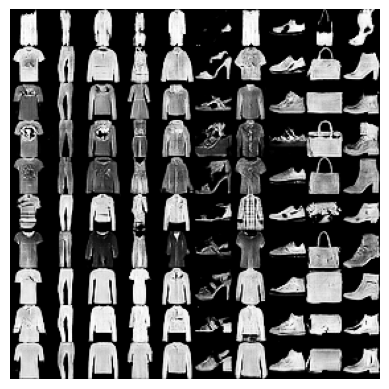

In [12]:
# test
cgan_runner.test()

Class: 0


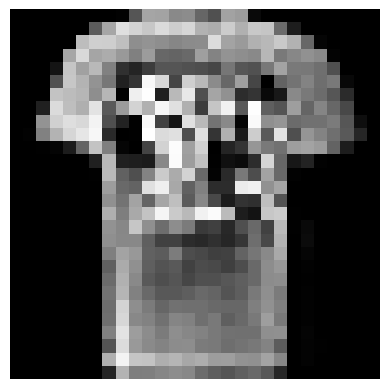

Class: 1


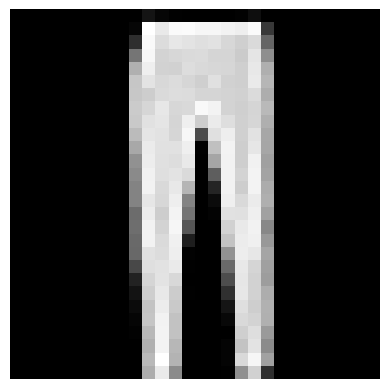

Class: 2


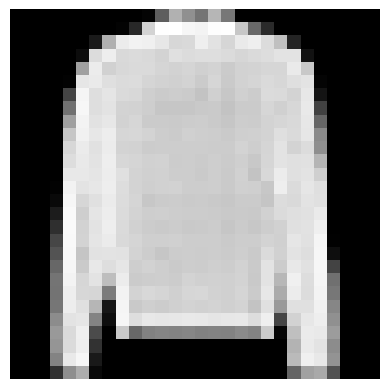

Class: 3


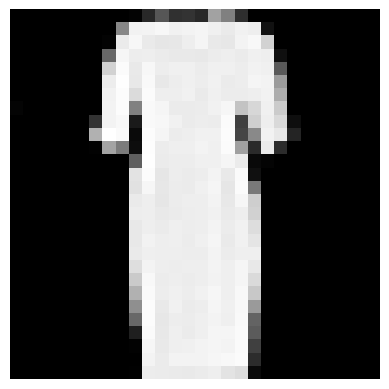

Class: 4


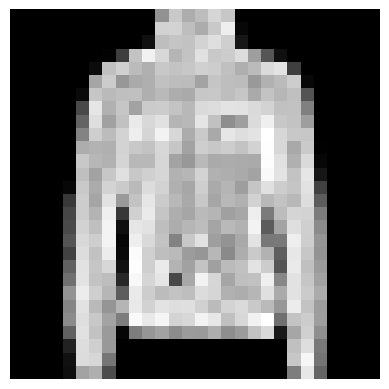

Class: 5


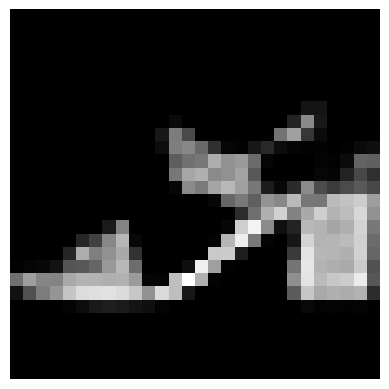

Class: 6


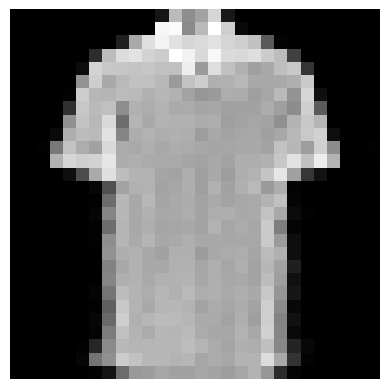

Class: 7


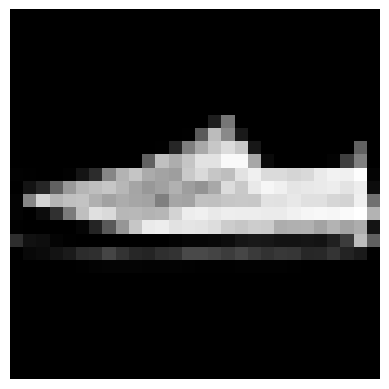

Class: 8


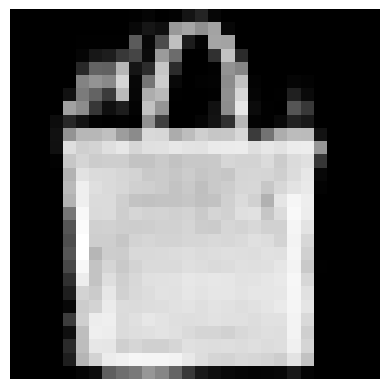

Class: 9


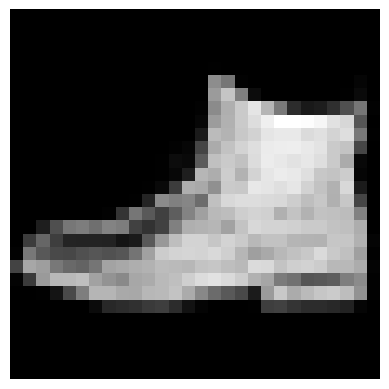

In [19]:
# generation
class_nums = torch.tensor([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]])
# class_nums = cgan_runner.vector_sampler.sample_classes(10)
sample_z_ = cgan_runner.vector_sampler.sample_z(len(class_nums))
cgan_runner.image_generation(class_type=class_nums, sample_z_=sample_z_)